---
title: Manufacturing Computation for Multi-layer Devices
bibFile: data/bib.json # path relative to project root
---

# Manufacturing Computation for Multi-layer Devices

### Hinge width, laminate thickness, and range of motion

The first thing to think about is how the thickness of your laminate will impact and alter the ideal kinematics you have been assuming up to this point. Let's first discuss hinges

A multilayer hinge typically is made by exposing a softer layer of material which is embedded in a multilayer laminate. IT is typically exposed along a straight line, and the cut away materail usually spans a straight line across the width of a material. In this way, once exposed, the soft material may bend and flex easily along an axis defined by that imaginary line.

![Range of Motion Comparision](/figures/design/rom_comparison.png)
![Range of Motion Comparision](../../../../static/figures/design/rom_comparison.png)

In [1]:
%matplotlib inline

In [2]:
import foldable_robotics
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import shapely.geometry as sg
foldable_robotics.resolution=4


The first assumption we make for narrow hinges is that the hinge actually rotates about one line. This is not necessarily a valid assumption in all cases, because by exposing an area of soft material we have essentially formed a cantilever beam which bends along its entire length. However, when the length of a hinge is small in comparison to other design geometries, it makes the computation of kinematics much simpler. So whenever possible we make that assumption. Some have attempted to create models which account for this behavior {{< cite "Odhner2012a" >}} in similar flexure joints.


The second problem is that the thickness of the material can interfere with itself at and around joints. Figure X highlights the problem. As the material rotates about a virtual joint defined by the midpoint of the flexure material, it can come into contact with itself much earlier than anticipated by the ideal, infinitely thin assumption. To determine the needed hinge length given a desired range of motion(b) and laminate thickness(t), you can use the equation (<!--\ref{eqn:lengthrule}-->), or conversely, (<!--\ref{eqn:rotationrule}-->).

![Thickness to Range of Motion Calc](../../../../static/figures/design/thickness_rom_calc.png)
![Thickness to Range of Motion Calc](/figures/design/thickness_rom_calc.png)

\begin{align}
\tan a &= \frac{\frac{t}{2}}{\frac{l}{2}} = \frac{t}{l}\\
a&=\tan^{-1} \left(\frac{t}{l}\right)\\
2a+\theta&=\pi\\
\theta&=\pi-2a\\
\theta&=\pi-2\tan^{-1} \left(\frac{t}{l}\right)\\
l&=\frac{t}{\tan(a)}\\
l&=\frac{t}{\tan\left(\frac{\pi-\theta}{2}\right)}
\end{align}

<!--\label{eqn:rotationrule} \label{eqn:lengthrule}-->

#### Selective reinforcement

This is really the simplest form of mitigation you can do. Use a thin material and reinforce as needed with extra material. This is an entirely customized process though, and assumes your original design was good enough to get you close enough to see what elements needed reinforcing.

You can reinforce in a couple ways. You can glue reinforcing material, from a coffee stirrer or piece of hand-cut balsa, to creating a fiberglass or carbon fiber reinforcement which gets laminated on

One of the benefits of this method is that you only have to reinforce where you need it. This is more of a guess and check strategy, and not too formulaic, which may not be too efficient, and for the novice, might

#### "Castellated" hinges

Castellated hinges address the material conflict issue by removing alternating portions of material near the joint so the radius of curvature remains small.  This only works with stiff rigid materials that are strong enough not to bend or break under the added stress of such small bend radii.  It does not typicallly work for cardboard.

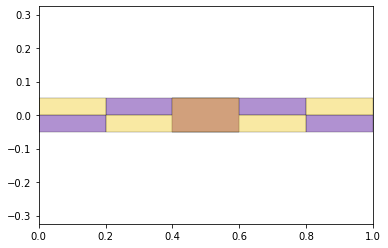

In [3]:
import foldable_robotics.parts.castellated_hinge1

hinge = foldable_robotics.parts.castellated_hinge1.generate()
hinge = hinge.scale(1,.1)
hinge.plot()


#### Alternating Hinge locations

![Alternating Hinges](/figures/design/alternating_hinges.png)

One way to address the problem of material thickness is to have joints which are asymmetrically located in the laminate stack. By having joints on the outer edges, rather than the inner edges of the laminate, you can make your laminate flat foldable at both 0 and 180 degrees. There are some underlying problems to this technique, however. Having your soft hinge material on the outside of your rigid material is an invitiation for delamination -- the material will just peel away unless you have sufficiently bonded your layers. If you are doing this in one material and simply scored the material from one side or another, this may help but you have also potentially created a stress concentration. A good way of doing this strategy would be via molding, where you can build in good flexure design practices ala howell in order to minimize stress while also locating a hinge along the top or bottom of a thick link. But then if you're doing that, hopefully you have exhausted your other, cheaper and easier options first.

### DXF creation

The benefit of prototyping in paper is that the design can be easily extracted from the pattern which is folded. One straightforward process to sketch a device involves highlighting each hinge of a paper mockup, and drawing that hinge pattern in a 2d sketching program. Two such programs, inkscape and draftsight, may be used interchangeably for this step. Many commercial and open-source programs permit dimensioning or defining 2d patterns, and we do not advocate or insist on any one in particular, rather the one you are comfortable with. If dimensions are important, you may need a CAD program in order to get it right. If you are at the sketching step simply looking to recreate a topology to be optimized later, any will work. Certain functionality, like being able to define and use layers and line colors will help later, and are recommended features to utilize during the sketching phase. While there are many potential exchange formats, we recommend finding a program which can output dxf's, specifically more modern ascii formats(R2013 ascii format will work fine.)

A foldable sketch consists of several elements. First, you must define the material layers. This may be accomplished by creating a closed shape. Material inside the shape indicates where material exists. Material outside the shape indicates where material isn't. DXF files provide several sometimes overlapping functionalities for drawing polygons or what look like polygons. The LWpolyline is a more recent addition to the dxf specification, and provides the ability to draw both lines and arcs within the same shape, and to indicate a "closed" polygon. The scripting language supports lw polylines, and can interpret arc segments as well, (even though it discretizes them as line segments for computation).

polylines are abstract implementations which do not always produce valid shapes for indicating the presence of material(closed area), so it is important to always draw with a few remembered rules. First, there is no computation of "inside" or "outside". While you can draw polylines where lines intersect or two vertices meet, these shapes are not valid for the purposes of specifiying material. Polylines do not keep track of "inside" or "outside" a shape so it is your job to, or to supply your import routine with the proper handling of self-contacting and self-intersecting shapes.

Secondly, there is no definition of a hole when drawing a polyline. Material with holes or cuts in it must be defined by multiple separate polylines. We will discuss how to gracefully compute this in a few lines of code, but for now, keep in mind that you should try to (for your own sake) make sure polylines don't intersect each other. There are ways to handle this, but there are multiple way sto handle it, and so the best way is to avoid the problem in the first place. Figure x shows two different representations for the same computed shape. Isn't it just easier to keep self-intersections to a minimum?

Another type of geometry which is required for foldable robotics is the definition of where hinges go. Think about a hinge. While the geometry required to actually fabricate a hinge may involve many layers and many shapes, it's placement in space often boils down to a straight line between two vertices. Create a layer called "hinges" and draw separate lines indicating the placement of each hinge.

Another type of geometry you may want to define separately is a cut. Cuts may be complex polylines, individual line segments, etc, but are different from the holes supplied in the material layer. Why? They typically indicate cut paths not areas. It is sometimes usefull to treat these things separately in your code. So make another layer called "cutlines" and draw any lines arcs, polylines, etc.

Another type of geometry with sometimes different requirements is circular holes.

Again, the above suggestions are simply that: suggestions for a sketching workflow which will help you organize your computations later. You can always put different geometries in different layers; you just need to then modify your script to handle all of them.

### Manufacturing Planning

This section summarizes recent work towards the development of a scriptable CAM environment which permits robots to be designed and built quickly using a suite of scripts which make the process seamless and repeatable. From a basic set of user assumptions, this scripting environment provides the rest while letting the user drive their design forward with

The goal of being able to rapidly develop a robot in the span of an hour or day has become more realistic as rapid prototyping tools have become more advanced.

### Material

Import all the polylines from the material layer into a list of shapes. These shapes may be approximated as a set of polygons. The final shape s may be computed as

$$s = \prod_{i = = 1}^{n}{}s_{i}$$

Where the $\prod_{}^{}{}$ operator

### Layer

A layer is a space in 2d which can define the allocation of material. Any regular shape can exist on it, including primitives like prisms, circles, ellipses, etc, but I like to think more in terms of polygons, or polyonal approximations of other things. Why? Polygons are easy to triangulate and to study. If you want to make a circle, make instead a circular polygon with many vertices. If you are willing to take the tolerance errors in that approximation, then you can take advantage of a suite of tools well suited to polygons.

Most importantly is the concept that a layer defines where material is or isn't. Inside a polygon there is material. Outside there isn't. That means on a layer of one material you can't have

-   Overlapping polygons

-   Standalone lines or polylines.

-   Complex or self-intersecting geometries.

All of these things need to either be simplified to a simple polygonal representation or eliminated from a layer.

Another assumption which arises from this assumption is that layers are not interesting in the third dimension; this is not always true with laser cutters, water-jet cutters, etc. Sometimes they are capable of producing high draft angles (the profiles they cut are not perfectly straight in the z direction) A layer cannot account for that on its own. Additionally, a layer does not know or care what the thickness of the layer is. Nor does it matter.

For the purposes of the next exercise, we will introduce two geometries, a circle and a triangle

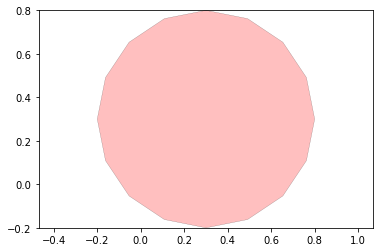

In [4]:
circle = Layer(sg.Point(0,0)) << .5
circle = circle.translate(.3,.3)
circle.plot()

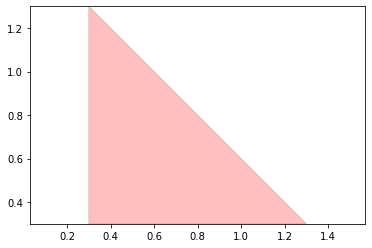

In [5]:
triangle = Layer(sg.Polygon([(0,0),(1,0),(0,1)]))
triangle = triangle.translate(.3,.3)
triangle.plot()

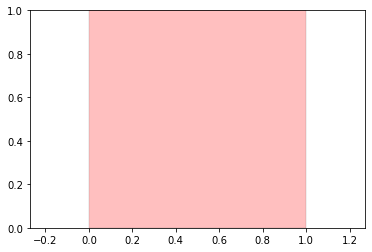

In [6]:
square = Layer(sg.Polygon([(0,0),(1,0),(1,1),(0,1)]))
square.plot()

Transformations

#### Operations

Union

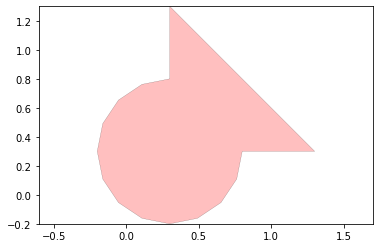

In [7]:
result = circle | triangle
result.plot()

Unary Union

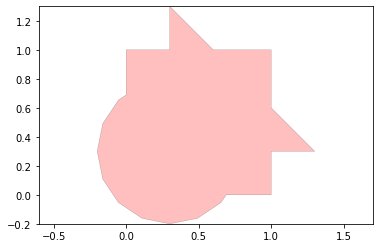

In [8]:
result = circle.unary_union(triangle,square)
result.plot()

Intersection

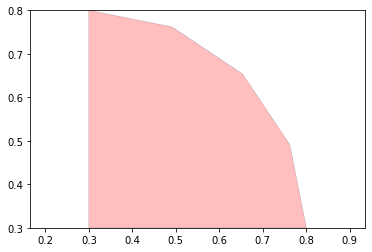

In [9]:
result = circle & triangle
result.plot()

Symmetric Difference

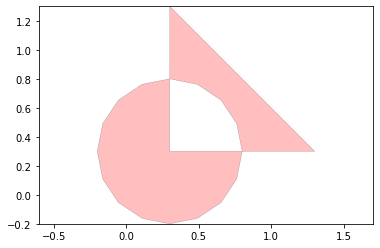

In [10]:
result = circle ^ triangle
result.plot()

Difference

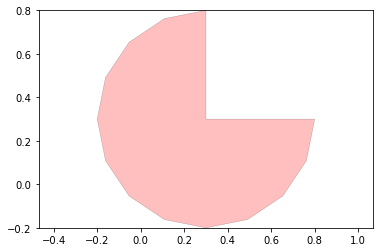

In [11]:
result = circle - triangle
result.plot()

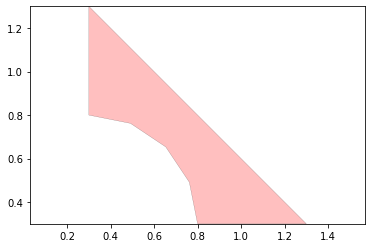

In [12]:
result = triangle - circle
result.plot()

Transformations

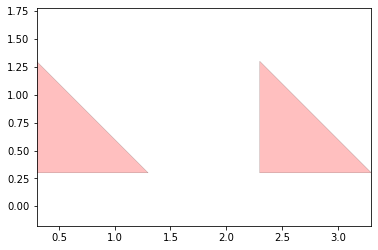

In [13]:
result = triangle | triangle.translate(2,0)
result.plot()

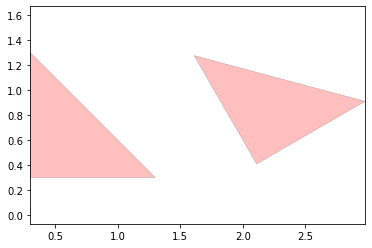

In [14]:
result = triangle |triangle.translate(2,0).rotate(30,(2,0))
result.plot()

Transformations

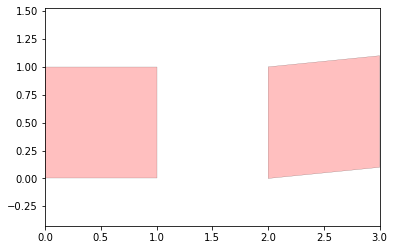

In [15]:
result = square | square.affine_transform([1,0,.1,1,2,0])
result.plot()

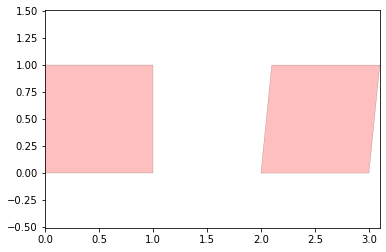

In [16]:
result = square | square.affine_transform([1,.1,0,1,2,0])
result.plot()

Dilation

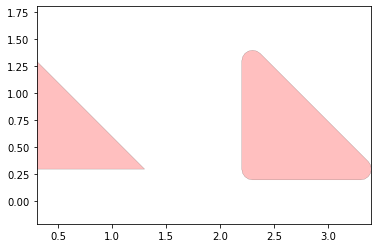

In [17]:
result = triangle | (triangle.translate(2,0) << .1)
result.plot()

Erosion

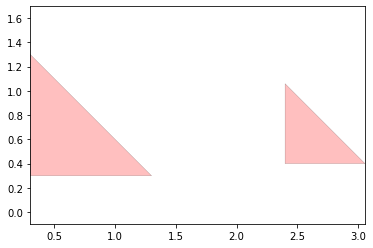

In [18]:
result = triangle | (triangle.translate(2,0) >> .1)
result.plot()

### Laminate

A Laminate is a collection of layers. A laminate enforces a particular ordering of layers, and a particular number of layers. This is established as a geometric ordering, rather than a time based ordering, etc. Therefore two polygons which overlap at the same x, y point, and exist the same layer in two laminates of the same size are assumed to be , thus can be operated upon. This means that laminates of idfferent numbers o flayers produce indeterminate results, thus there are no operations defined for them.

Laminates don't on their own hold

Thickness

Material type

Sequence of addition

This means that a laminate representation cannot represent complex laminates in which layers change their thickness, change their z-elevation, have multiple materials on the same layer, etc.

You can create an empty laminate of an arbitrary number by joining several empty layers together. You can augment an existing laminate with empty layers to make it operable against a laminate of a different size. You can eliminate layers to make it smaller and operable against a smaller laminate.

Laminate specific operations

Create

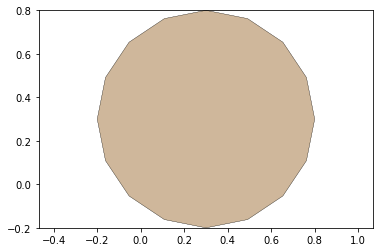

In [19]:
circle_lam = Laminate(circle,circle,circle)
circle_lam.plot()

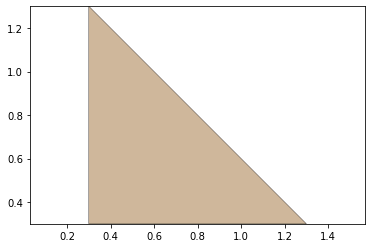

In [20]:
triangle_lam = Laminate(triangle,triangle,triangle)
triangle_lam.plot()

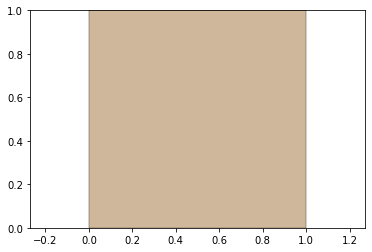

In [21]:
square_lam = Laminate(square,square,square)
square_lam.plot()

Select

<class 'foldable_robotics.layer.Layer'>


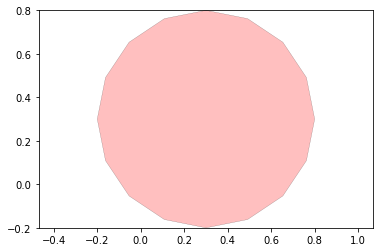

In [22]:
print(type(circle_lam[0]))
circle_lam[0].plot()

All layer operations can be applied to laminates. This includes

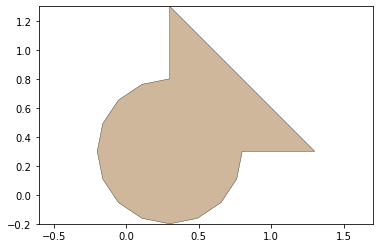

In [23]:
result = circle_lam|triangle_lam
result.plot()

Append / Expand

Layer-specific extensions

Unary operations

Binary operations

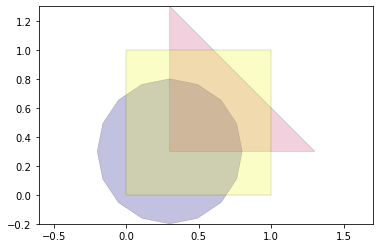

In [24]:
lam = Laminate(circle,triangle,square)
lam.plot()

Shift Up

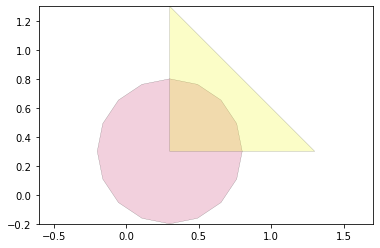

In [25]:
result = Laminate(Layer(),*lam[:-1])
result.plot()

Shift Down

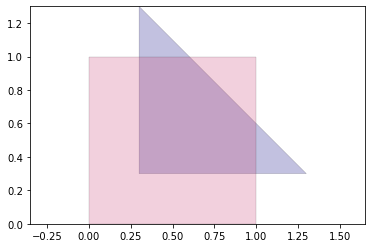

In [26]:
result = Laminate(*lam[1:],Layer())
result.plot()

Rotate Up

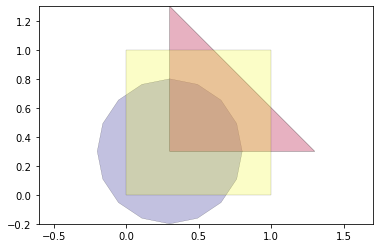

In [27]:
result = Laminate(*lam[:-1],*lam[1:])
result.plot()

Rotate Down

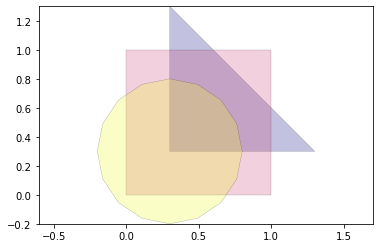

In [28]:
result = Laminate(*lam[1:],*lam[:1])
result.plot()

## Bibliography

{{< bibliography cited >}}
